# Data Wrangling

In this notebook we clean and tidy our data, and save analysis and modeling for [another notebook](./analysis-and-modeling.ipynb)

<h2><span class="tocSkip">Table of Contents</span></h2>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gather-and-Assess" data-toc-modified-id="Gather-and-Assess-4.0.1">Gather and Assess</a></span></li><li><span><a href="#Clean-and-Tidy" data-toc-modified-id="Clean-and-Tidy-4.0.2">Clean and Tidy</a></span><ul class="toc-item"><li><span><a href="#listings-dataset" data-toc-modified-id="listings-dataset-4.0.2.1"><code>listings</code> dataset</a></span></li><li><span><a href="#calendar-dataset" data-toc-modified-id="calendar-dataset-4.0.2.2"><code>calendar</code> dataset</a></span></li></ul></li><li><span><a href="#Create-amenities-features." data-toc-modified-id="Create-amenities-features.-4.0.3">Create amenities features.</a></span></li><li><span><a href="#Save-cleaned-datasets" data-toc-modified-id="Save-cleaned-datasets-4.0.4">Save cleaned datasets</a></span></li></ul></li></div>

In [93]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style('darkgrid')
import re

from collections import defaultdict
from pandas.api.types import CategoricalDtype
from functools import partial
from matplotlib.axes._axes import _log as matplotlib_axes_logger

# settings
pd.set_option('display.max_columns', None)
matplotlib_axes_logger.setLevel('ERROR')

## Gather and Assess 

The data we're using was compiled by [InsideAirBnb](http://insideairbnb.com/) from information made publicly available on [AirBnb](http://airbnb.com). Some interesting disclaimers about the data can be found at the [about page](http://insideairbnb.com/about.html) as well as more about Inside AirBnb's model for estimating occupancy rate. You can find datasets for a very large number of major cities worldwide [here](http://insideairbnb.com/about.html).

For each city, InsideAirBnb provides data sets which are updated roughly monthly. Let's collect the most recent available for Vancouver, Seattle, and Portland -- this is 

In [ ]:
# download and unzip data to /data
! sh getdata.sh

--2020-03-05 21:15:56--  http://data.insideairbnb.com/united-states/or/portland/2020-02-13/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.32.131
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.32.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6002650 (5.7M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]   5.72M  4.71MB/s    in 1.2s    

2020-03-05 21:15:58 (4.71 MB/s) - ‘listings.csv.gz’ saved [6002650/6002650]

--2020-03-05 21:15:58--  http://data.insideairbnb.com/united-states/or/portland/2020-02-13/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.32.131
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.32.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5449097 (5.2M) [application/x-gzip]
Saving to: ‘calendar.csv.gz’

calendar.csv.gz     100%[===================>]

After unzipping and renaming, we have 3 data files for each city.


|File Name               | Description                                |
|------------------------|--------------------------------------------|
| listings.csv           | Detailed Listings data                     |
| calendar.csv           | Detailed Calendar data for listings        |
| neighbourhoods.geojson | GeoJSON file of neighbourhoods of the city.|

These can all be found in the `/data` directory.

In [2]:
def load_dfs(file_prefixes, city_names, files_path):
    """Load all but .geojson data files for each city into nested dict of dataframes."""
    dfs = defaultdict(dict)

    for file_prefix in file_prefixes:
        for city_name in city_names:
            file_path = files_path + city_name + '_' + file_prefix + '.csv'
            dfs[file_prefix][city_name] = pd.read_csv(file_path)

    return dfs

file_prefixes = ['listings', 'calendar']
city_names = ['seattle', 'portland', 'vancouver']
files_path = 'data/'
dfs = load_dfs(file_prefixes, city_names, files_path)

/Users/home/opt/anaconda3/envs/cascbnb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Some of the questions we're interested in involve comparisons between the three cities, so we'll merge the corresponding dataframes for each city into a single large dataframe.

In [3]:
def merge_dfs(dfs, file_prefixes, city_names):
    """Merge dataframes for each kind of data file."""
    merged_dfs = defaultdict(list)
    
    for file_prefix in file_prefixes:
        dfs_list = [dfs[file_prefix][city_name] for city_name in city_names]
        merged_dfs[file_prefix] = pd.concat(dfs_list, keys=city_names, names=['city'])
        try:
            merged_dfs[file_prefix].drop(columns=['city'], inplace=True)
        except:
            pass

    return merged_dfs
        
dfs = merge_dfs(dfs, file_prefixes, city_names)

The main dataset we'll be relying on is the `listings` dataset.

In [4]:
listings_df = dfs['listings']
listings_df.head(3)

id                        listing_url       scrape_id  \
city                                                                 
seattle 0  2318  https://www.airbnb.com/rooms/2318  20191121092259   
        1  5682  https://www.airbnb.com/rooms/5682  20191121092259   
        2  6606  https://www.airbnb.com/rooms/6606  20191121092259   

          last_scraped                                               name  \
city                                                                        
seattle 0   2019-11-21  Casa Madrona - Urban Oasis 1 block from the park!   
        1   2019-11-21                Cozy Studio, min. to downtown -WiFi   
        2   2019-11-21                Fab, private seattle urban cottage!   

                                                     summary  \
city                                                           
seattle 0  Gorgeous, architect remodeled, (Phone number h...   
        1  The Cozy Studio is a perfect launchpad for you...   
        2  This tiny cottage is only 15x10, but it has ev...   

                                                       space  \
city                                                           
seattle 0  This beautiful, gracious home has been complet...   
        1  Hello fellow travelers, Save some money and ha...   
        2  Soo centrally located, this is a little house ...   

                                                 description  \
city                                                           
seattle 0  Gorgeous, architect remodeled, (Phone number h...   
        1  The Cozy Studio is a perfect launchpad for you...   
        2  This tiny cottage is only 15x10, but it has ev...   

          experiences_offered  \
city                            
seattle 0                none   
        1                none   
        2                none   

                                       neighborhood_overview  \
city                                                           
seattle 0  Madrona is a hidden gem of a neighborhood. It ...   
        1                                                NaN   
        2  A peaceful yet highly accessible neighborhood,...   

                                                       notes  \
city                                                           
seattle 0  We adhere to a 10pm -9am quiet hour schedule, ...   
        1  My personal favorite places to dine are:  • Ma...   
        2  Check in is at three, if you'd like a snack or...   

                                                     transit  \
city                                                           
seattle 0                                                NaN   
        1  Bus 120 is right outside and goes into downtow...   
        2                                                NaN   

                                                      access  \
city                                                           
seattle 0           Guests can access any part of the house.   
        1  PRIVATE ENTRANCE WITH PRIVATE BATH Queen size ...   
        2                                                NaN   

                                                 interaction  \
city                                                           
seattle 0  We are a family who live next door and are ava...   
        1  I'm more than happy to meet with guests, but u...   
        2  I often escape to kingston and my place on the...   

                                                 house_rules  thumbnail_url  \
city                                                                          
seattle 0                                                NaN            NaN   
        1  **PLEASE READ** NO SMOKING NO VAPING NO MARIJU...            NaN   
        2  Please treat the cottage as if it were your ow...            NaN   

           medium_url                                        picture_url  \
city                                                                  

In [5]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19997 entries, ('seattle', 0) to ('vancouver', 6180)
Columns: 105 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(62)
memory usage: 16.1+ MB


There are 19997 total listings, with 105 columns. Columns are well named and descriptive enough to make sense of the variables they correspond to. We note that lot of these variables are long text strings. This dataset provides a lot of interesting opportunities for natural language processing.

We'll also be making use of the `calendar` dataset

In [6]:
calendar_df = dfs['calendar']
calendar_df.head(3)

listing_id        date available    price adjusted_price  \
city                                                                  
seattle 0        2318  2019-11-21         f   $99.00         $99.00   
        1      202251  2019-11-21         f  $175.00        $175.00   
        2      202251  2019-11-22         f  $175.00        $175.00   

           minimum_nights  maximum_nights  
city                                       
seattle 0               7            1000  
        1              30             150  
        2              30             150

In [7]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7298905 entries, ('seattle', 0) to ('vancouver', 2256064)
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 449.7+ MB


There are 7298905 calendar entries, with 7 variables describing them. Again column names are descriptive.

## Clean and Tidy


#### `listings` dataset

##### Drop rows/columns

First we check for duplicates

In [8]:
# number of duplicate rows
num_dups = listings_df.duplicated().sum()
num_dups

0

Next we'll looks at rows or columns containing a lot of missing values. We'll choose a lower threshold of 25% missing values

In [9]:
def prop_missing_vals_df(df, axis=0, threshold=0.25, ascending=False):
    """Get missing values in df by proportion above threshold along axis."""
    prop = df.isna().sum(axis=axis).sort_values(ascending=ascending)
    prop = prop/df.shape[axis]
    prop.name = 'prop_miss_vals'
    return pd.DataFrame(prop[prop > threshold])

In [10]:
# rows with high proportion of missing values in listings df
prop_missing_vals_df(listings_df, axis=1, threshold=0.25)

prop_miss_vals
city                          
vancouver 6065        0.342857
          3403        0.323810
portland  4756        0.323810
seattle   8919        0.323810
vancouver 3574        0.323810
...                        ...
seattle   3677        0.257143
          7598        0.257143
          4790        0.257143
          7599        0.257143
vancouver 5882        0.257143

[475 rows x 1 columns]

There are quite 475 rows missing more than 25% of values, but no rows are missing 100% of values. 
We'll address these missing values by column instead.

In [11]:
# columns with high proportion of missing values in listings df
prop_missing_vals_df(listings_df, axis=0, threshold=0.25)

,prop_miss_vals
host_acceptance_rate,1.000000
medium_url,1.000000
xl_picture_url,1.000000
thumbnail_url,1.000000
square_feet,0.963545
monthly_price,0.906486
weekly_price,0.890784
neighbourhood_group_cleansed,0.548782
license,0.489873
notes,0.430365


Inspecting each of these more carefully, we'll drop all of these columns for the following reasons:

- `interaction`, `neighbourhood_overview`, `transit`, `host_about`, `access`, `notes`: These are all text fields which would require somewhat sophisticated NLP.
- `neighbourhood_group_cleansed`: Large proportion of missing values and we can get more precise information from `neighborhood`
- `weekly_price`, `monthly_price`: Large proportion of missing values and we're more interested in (daily) `price`
- `square_feet`, `thumbnail_url`, `xl_picture_url`, `medium_url`, `host_acceptance_rate`: Too high percentage of missing values to be useful.
- `license`: Irrelevant to our analysis

In [12]:
# start collecting columns to drop from listings df
drop_cols = set(prop_missing_vals_df(listings_df, axis=0).index)

There are quite a few more columns we can drop. To make this easier to manage, lets display columns of `listings` in alphabetical order:

In [13]:
# alphabetize columns besides those selected for dropping and inspect
alph_cols = list(set(listings_df.columns).difference(drop_cols))
alph_cols.sort()
listings_df[alph_cols].head(1)

,,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,name,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,state,street,summary,zipcode
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seattle,0,9,"{Internet,Wifi,Kitchen,""Free parking on premis...",6,59,29,59,2.5,Real Bed,4.0,4.0,2,2,0,0,2019-11-21,5 days ago,strict_14_with_grace_period,$250.00,United States,US,"Gorgeous, architect remodeled, (Phone number h...",none,$25.00,2008-09-15,8,t,t,2536,f,t,2.0,"Seattle, Washington, United States",Megan,Minor,https://a0.muscache.com/im/pictures/user/016a1...,100%,within an hour,2008-08-26,https://a0.muscache.com/im/pictures/user/016a1...,2.0,https://www.airbnb.com/users/show/2536,"['email', 'phone', 'reviews', 'jumio', 'offlin...",NaN,2318,t,f,t,"{WASHINGTON,"" Seattle"","" WA""}",2019-10-31,2019-11-21,47.61082,https://www.airbnb.com/rooms/2318,-122.29082,Seattle,1000,7,1000,1000.0,1000,7,7,7.0,Casa Madrona - Urban Oasis 1 block from the park!,Madrona,Madrona,29,9,https://a0.muscache.com/im/pictures/02973ad3-a...,$296.00,House,f,f,t,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.21,Entire home/apt,20191121092259,$500.00,"Seattle, WA","This beautiful, gracious home has been complet...",WA,"Seattle, WA, United States","Gorgeous, architect remodeled, (Phone number h...",98122


We'll also drop the following columns for the following reasons:

- `description`, `house_rules`, `name`, `space`, `summary`: long string text columns that could be useful but would require some NLP (which is beyond this scope of this project). 
- `calendar_updated`, `host_location`, `host_name`, `host_neighbourhood`, `host_picture_url`,  `host_thumbnail_url`, `host_url`, `host_verifications`, `is_location_exact`, `jurisdiction_names`, `listing_url`, `market`, `name`, `picture_url`, `scrape_id`: Irrelevant for our analysis
- `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights`, `minimum_minimum_nights`,  `minimum_nights_avg_ntm`, `maximum_nights_avg_ntm` - Difficult to interpret and possibly less relevant (given presence of `minimum_nights`, `maximum_nights`)
- `last_scraped`, `calendar_last_scraped`, `country`, `country_code`, `experiences_offered`, `has_availability`: All have the same value for this dataset
- `host_has_profile_pic`: Extreme class imbalance (99.8% vs. 0.2%).
- `smart_location`: Highly imbalanced and superceded by other variables.
- `street`: Doesn't even contain street information!
- `state`: Redundant (given city information) and not relevant
- `zipcode`: Superceded by other more useful geographic variables (`neighbourhood`, `latitude`, `longitude`)
- `host_listings_count`, `host_total_listings_count`, `neighbourhood`: Appears to be from original AirBnB data - superceded by other variables created by Inside AirBnB (names beginning    with prefix `calculated_`)
- `number_of_reviews_ltm` - meaning unclear

That was a lot of detailed justification, but it can be helpful to be explicit and clear about reasons for ignoring information.

In [14]:
# add remaining columns to drop and drop
more_drop_cols = {'description', 'house_rules', 'name', 'space', 'summary', 'calendar_updated', 'host_location',
                  'host_name', 'host_neighbourhood', 'host_picture_url', 'host_thumbnail_url', 'host_url', 
                  'host_verifications', 'is_location_exact', 'jurisdiction_names', 'listing_url', 'market', 
                  'name', 'picture_url', 'scrape_id', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                  'maximum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm', 'last_scraped', 'calendar_last_scraped', 'country', 'country_code', 
                  'experiences_offered', 'has_availability', 'host_has_profile_pic', 'smart_location', 'street', 
                  'state', 'host_listings_count', 'host_total_listings_count', 'neighbourhood', 'zipcode', 
                  'number_of_reviews_ltm'}
drop_cols = drop_cols.union(more_drop_cols)
listings_df = listings_df.drop(columns=drop_cols)

In [15]:
def alphabetize_cols(df, first_col='id'):
    """Alphabetize columns."""
    df_cp = df.copy()
    alph_cols = list(df_cp.columns.sort_values())
    alph_cols.remove(first_col)
    alph_cols = [first_col] + alph_cols
    df_cp = df_cp[alph_cols]
    return df_cp

listings_df = alphabetize_cols(listings_df)

##### Enforce dtypes

Now that we're left with the variables we're interested in, we'll see if any need processing before we deal with missing values and setting dtypes

In [16]:
listings_df.select_dtypes('int64').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19997 entries, ('seattle', 0) to ('vancouver', 6180)
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   id                                            19997 non-null  int64
 1   accommodates                                  19997 non-null  int64
 2   availability_30                               19997 non-null  int64
 3   availability_365                              19997 non-null  int64
 4   availability_60                               19997 non-null  int64
 5   availability_90                               19997 non-null  int64
 6   calculated_host_listings_count                19997 non-null  int64
 7   calculated_host_listings_count_entire_homes   19997 non-null  int64
 8   calculated_host_listings_count_private_rooms  19997 non-null  int64
 9   calculated_host_listings_count_shared_rooms   19997 non-

All of the variables with integer type look good. Also since `np.nan` is a float, we can conclude all these variables have no missing values

In [17]:
listings_df.select_dtypes('float64').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19997 entries, ('seattle', 0) to ('vancouver', 6180)
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bathrooms                    19992 non-null  float64
 1   bedrooms                     19983 non-null  float64
 2   beds                         19986 non-null  float64
 3   latitude                     19997 non-null  float64
 4   longitude                    19997 non-null  float64
 5   review_scores_accuracy       17308 non-null  float64
 6   review_scores_checkin        17304 non-null  float64
 7   review_scores_cleanliness    17308 non-null  float64
 8   review_scores_communication  17308 non-null  float64
 9   review_scores_location       17304 non-null  float64
 10  review_scores_rating         17310 non-null  float64
 11  review_scores_value          17305 non-null  float64
 12  reviews_per_month            17413 non-null  fl

All of these variables are indeed numerical. Some of them could be converted to ints -- this may speed computations and reduce the chance of rounding errors. Since `np.nan` is a float however, we'll wait until after we handle missing values. Let's look at which floats can be safely converted to ints.

In [18]:
def can_conv_to_int(list_float_vars):
    """Check which float values can be converted to int without rounding."""
    res = (np.abs(np.floor(list_float_vars) - list_float_vars) > 0).any()
    return ~ res

In [19]:
# dictionary for tracking col dtype conversions
conv_dtypes = defaultdict(set)
# see which float columns can be safely converted to int
conv_to_int = can_conv_to_int(listings_df.select_dtypes('float64').dropna())
conv_to_int_cols = set(conv_to_int[conv_to_int.T].index)
conv_dtypes['int'] = conv_to_int_cols
conv_dtypes['int']

{'bedrooms',
 'beds',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value'}

So we can safely convert all but `reviews_per_month`, `longitude`, `latitude`, and `bathrooms` to integer type (after we've dealt with missing values)

Finally let's look at object variables

In [20]:
listings_df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19997 entries, ('seattle', 0) to ('vancouver', 6180)
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   amenities                         19997 non-null  object
 1   bed_type                          19997 non-null  object
 2   cancellation_policy               19997 non-null  object
 3   cleaning_fee                      18441 non-null  object
 4   extra_people                      19997 non-null  object
 5   first_review                      17413 non-null  object
 6   host_identity_verified            19986 non-null  object
 7   host_is_superhost                 19986 non-null  object
 8   host_response_rate                17018 non-null  object
 9   host_response_time                17018 non-null  object
 10  host_since                        19986 non-null  object
 11  instant_bookable                  19997 non-null  obj

In [21]:
listings_df.select_dtypes('object').head(1)

,,amenities,bed_type,cancellation_policy,cleaning_fee,extra_people,first_review,host_identity_verified,host_is_superhost,host_response_rate,host_response_time,host_since,instant_bookable,is_business_travel_ready,last_review,neighbourhood_cleansed,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,room_type,security_deposit
city,,,,,,,,,,,,,,,,,,,,,,,
seattle,0,"{Internet,Wifi,Kitchen,""Free parking on premis...",Real Bed,strict_14_with_grace_period,$250.00,$25.00,2008-09-15,f,t,100%,within an hour,2008-08-26,t,f,2019-10-31,Madrona,$296.00,House,f,f,t,Entire home/apt,$500.00


Some of these variables can be converted to other appropriate types, without additional processing. We're careful not to cast to boolean dtype with missing data since pandas will automatically convert `np.nan` to `True`

In [22]:
# non-ordered categorical variables
conv_dtypes['categorical'] = {'host_identity_verified', 'host_is_superhost', 'instant_bookable', 
                              'is_business_travel_ready', 'neighbourhood_cleansed', 'property_type', 
                              'require_guest_phone_verification', 'require_guest_profile_picture', 
                              'requires_license'}
conv_dtypes['datetime'] = {'first_review', 'host_since', 'last_review'}

listings_df.loc[:, conv_dtypes['categorical']] = listings_df[conv_dtypes[
                                                 'categorical']].astype('category')
listings_df.loc[:, conv_dtypes['datetime']] = listings_df[conv_dtypes['datetime']]\
                                           .astype('datetime64')

We also have a some categorical data types with natural orderings, since there's a natural way of assigning a price value to them.

In [23]:
def set_ord_cat_dtypes(listings_df, conv_dtypes, ord_cat_cols):
    """Set ordered categorical columns dtypes."""
    listings_df_cp = listings_df.copy()
    for (col, ordering) in conv_dtypes['ordered_categorical'].items():
        dtype = CategoricalDtype(categories=ordering, ordered=True)
        listings_df_cp[col] = listings_df_cp[col].astype(dtype)
    return listings_df_cp

In [24]:
# ordered categorical variables
ord_cat_cols = ['bed_type', 'cancellation_policy', 'host_response_time', 'room_type']
conv_dtypes['ordered_categorical'] = {col:None for col in ord_cat_cols}
conv_dtypes['ordered_categorical']['bed_type'] = ['Couch', 'Airbed', 'Pull-out Sofa', 
                                                  'Futon', 'Real Bed']
conv_dtypes['ordered_categorical']['cancellation_policy'] = ['super_strict_60', 
                                                             'super_strict_30', 
                                                             'strict', 
                                                             'strict_14_with_grace_period', 
                                                             'moderate', 'flexible']
conv_dtypes['ordered_categorical']['host_response_time'] = ['within an hour', 
                                                            'within a few hours', 
                                                            'within a day', 
                                                            'a few days of more']
conv_dtypes['ordered_categorical']['room_type'] = ['Shared room', 'Hotel room', 
                                                   'Private room', 'Entire home/apt']
listings_df = set_ord_cat_dtypes(listings_df, conv_dtypes, ord_cat_cols)

Finally, some of the object variables need to be processed. Some can be easily converted to floats -- in this case, it doesn't matter if `np.nan` is present or not.

In [25]:
def conv_to_float(entry):
    """Float conversion helper."""
    try:
        return entry.replace('$', '').replace('%', '').replace(',', '')
    except AttributeError:
        return entry
    
def conv_cols(listings_df, conv_dtypes, conv_func, dtype_name):
    """Process/convert columns."""
    listings_df_cp = listings_df.copy()

    for col in conv_dtypes[dtype_name]:
        listings_df_cp[col] = listings_df[col].apply(conv_func)\
                              .astype(dtype_name)

    return listings_df_cp

In [26]:
# some float variables
conv_dtypes['float'] = {'cleaning_fee', 'extra_people', 'price', 
                        'security_deposit', 'host_response_rate'}
listings_df = conv_cols(listings_df, conv_dtypes, conv_to_float, 'float')

##### Missing Values

Now we'll take a look at missing values

In [27]:
# columns in listings dataset missing values
miss_vals_df = prop_missing_vals_df(listings_df, axis=0, threshold=0)
miss_vals_df = pd.DataFrame({'col': miss_vals_df.index, 
                            'prop_miss': miss_vals_df['prop_miss_vals'].values, 
                             'dtype': listings_df[miss_vals_df.index].dtypes})
miss_vals_df

,col,prop_miss,dtype
security_deposit,security_deposit,0.162224,float64
host_response_time,host_response_time,0.155073,category
host_response_rate,host_response_rate,0.148972,float64
review_scores_location,review_scores_location,0.134670,float64
review_scores_checkin,review_scores_checkin,0.134670,float64
review_scores_value,review_scores_value,0.134620,float64
review_scores_communication,review_scores_communication,0.134470,float64
review_scores_cleanliness,review_scores_cleanliness,0.134470,float64
review_scores_accuracy,review_scores_accuracy,0.134470,float64
review_scores_rating,review_scores_rating,0.134370,float64


First focussing on review-related variables missing variables, we notice the proportion of missing values is very close.

In [28]:
# review related variables missing values
miss_val_rev_cols = [col for col in miss_vals_df.index if 'review' in col]
miss_vals_df.loc[miss_val_rev_cols, :]

,col,prop_miss,dtype
review_scores_location,review_scores_location,0.134670,float64
review_scores_checkin,review_scores_checkin,0.134670,float64
review_scores_value,review_scores_value,0.134620,float64
review_scores_communication,review_scores_communication,0.134470,float64
review_scores_cleanliness,review_scores_cleanliness,0.134470,float64
review_scores_accuracy,review_scores_accuracy,0.134470,float64
review_scores_rating,review_scores_rating,0.134370,float64
last_review,last_review,0.129219,datetime64[ns]
first_review,first_review,0.129219,datetime64[ns]
reviews_per_month,reviews_per_month,0.129219,float64


We're both interested in the review variables as responses varialbes, so imputing is problematic, especially given the high percentage of missing values. Moreover, it's possible that the some listings are missing values for all review variables.

In [29]:
# prop of listings missing all review variables
miss_val_rev_df = listings_df[listings_df[miss_val_rev_cols].isna().T.all()]\
                            [miss_val_rev_cols]
len(miss_val_rev_df)/len(listings_df)

0.12921938290743612

So almost all of the variables missing some review information are missing all review information. Let's compare summary statistics for the listings missing all review information to summary statistics for the entire dataset.

In [30]:
# summary statistics for listings missing review variable values
listings_df.loc[miss_val_rev_df.index].describe()

,id,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cleaning_fee,extra_people,guests_included,host_id,host_response_rate,latitude,longitude,maximum_nights,minimum_nights,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,security_deposit
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2582.000000,2580.000000,2579.000000,2584.000000,2584.000000,2584.000000,2584.000000,2063.000000,2584.000000,2584.00000,2.584000e+03,1910.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1926.000000
mean,3.189247e+07,3.416022,14.587848,167.915248,31.515480,49.890480,1.341402,1.393411,1.735169,53.870743,50.275155,0.811146,0.481811,114.153660,9.485294,1.76548,9.641277e+07,95.232461,47.742109,-122.647902,783.446207,15.767028,0.0,234.905573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,449.813084
std,9.100052e+06,1.980135,12.569467,142.135922,24.438435,36.461574,0.664394,0.980557,1.287904,95.030714,95.137839,2.437277,4.258995,100.838623,18.016354,1.45548,1.023718e+08,15.443586,1.299767,0.345294,522.064630,28.748874,0.0,434.047504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,768.516977
min,6.850800e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.877000e+03,0.000000,45.434910,-123.218790,1.000000,1.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,2.929952e+07,2.000000,0.000000,27.000000,0.000000,5.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,50.000000,0.000000,1.00000,8.784515e+06,99.000000,47.598788,-123.097347,120.000000,1.000000,0.0,90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,3.498177e+07,3.000000,15.000000,143.000000,37.000000,59.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,89.000000,0.000000,1.00000,4.800549e+07,100.000000,47.625695,-122.586665,1125.000000,2.000000,0.0,149.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.000000
75%,3.857895e+07,4.000000,28.000000,332.000000,57.000000,87.000000,1.500000,2.000000,2.000000,45.000000,44.000000,1.000000,0.000000,140.000000,15.000000,2.00000,1.715433e+08,100.000000,49.242865,-122.336350,1125.000000,30.000000,0.0,219.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000
max,4.026163e+07,16.000000,30.000000,365.000000,60.000000,90.000000,8.500000,13.000000,16.000000,346.000000,346.000000,27.000000,58.000000,660.000000,250.000000,16.00000,3.109613e+08,100.000000,49.293880,-122.240950,9999.000000,365.000000,0.0,12800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6709.000000


In [31]:
# summary statistics for full listings dataset
listings_df.describe()

,id,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cleaning_fee,extra_people,guests_included,host_id,host_response_rate,latitude,longitude,maximum_nights,minimum_nights,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,security_deposit
count,1.999700e+04,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19992.000000,19983.000000,19986.000000,19997.000000,19997.000000,19997.000000,19997.000000,18441.000000,19997.00000,19997.000000,1.999700e+04,17018.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,17308.000000,17304.000000,17308.000000,17308.000000,17304.000000,17310.000000,17305.000000,17413.000000,16753.000000
mean,2.260711e+07,3.568485,12.804621,147.394359,28.320398,46.473621,1.292717,1.403643,1.862404,18.436015,16.426214,0.767065,0.284193,77.806518,13.53648,1.981297,7.537151e+07,97.836585,47.628184,-122.650023,606.383808,7.169425,53.169175,165.244137,9.748671,9.814263,9.637624,9.826265,9.800740,95.362276,9.518405,2.583847,297.188921
std,1.163275e+07,2.146671,11.007080,128.033973,21.491942,32.652092,0.625061,1.016977,1.391450,58.038053,57.298239,2.150273,3.424053,66.013358,22.27327,1.577767,8.683503e+07,9.501040,1.371816,0.335283,897.908660,20.220422,79.881167,245.980026,0.689114,0.612864,0.748148,0.612677,0.532097,6.915321,0.777649,2.342084,505.087617
min,2.318000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,2.000000e+01,0.000000,45.434560,-123.218790,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,2.000000,0.010000,0.000000
25%,1.368976e+07,2.000000,0.000000,32.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,35.000000,0.00000,1.000000,8.534462e+06,100.000000,47.526650,-123.073630,30.000000,1.000000,3.000000,79.000000,10.000000,10.000000,9.000000,10.000000,10.000000,94.000000,9.000000,0.640000,0.000000
50%,2.325198e+07,3.000000,12.000000,115.000000,30.000000,52.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,60.000000,7.00000,1.000000,3.638870e+07,100.000000,47.626650,-122.616150,730.000000,2.000000,20.000000,115.000000,10.000000,10.000000,10.000000,10.000000,10.000000,97.000000,10.000000,1.960000,200.000000
75%,3.318298e+07,4.000000,23.000000,269.000000,48.000000,76.000000,1.500000,2.000000,2.000000,4.000000,2.000000,1.000000,0.000000,100.000000,20.00000,2.000000,1.182731e+08,100.000000,49.239670,-122.337640,1125.000000,3.000000,70.000000,183.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99.000000,10.000000,3.960000,450.000000
max,4.026163e+07,28.000000,30.000000,365.000000,60.000000,90.000000,16.000000,30.000000,49.000000,346.000000,346.000000,27.000000,58.000000,700.000000,399.00000,16.000000,3.109613e+08,100.000000,49.293880,-122.240950,100000.000000,998.000000,795.000000,13000.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,10.000000,17.390000,6709.000000


The summary statistics suggest that, for listings missing review information the distributions of variables are different, than the distributions for all listings, so dropping these listings could bias the results. However, our analysis focuses on review variables, and moreover since they will be used as response variables, imputation seems like a bad plan. We'll go ahead drop rows missing any review variables

In [32]:
# drop rows missing any review variables
mask = listings_df[miss_val_rev_cols].isna().sum(axis=1) == 0
listings_df = listings_df[mask]

We'll also drop `last_review` and `first_review` columns as these are probably not too relevant for our analysis (although `number_of_reviews` and `reviews_per_month` will be)

In [33]:
# drop two more review columns
listings_df = listings_df.drop(columns=['first_review', 'last_review'])

Now focusing on the variables `bathrooms`, `beds`, `host_since`, `host_is_superhost`, `host_identity_verified`, and `bedrooms`, we notice all have less than 1% missing values, so simple imputation choices seem unproblematic here. Let's look at their distributions.

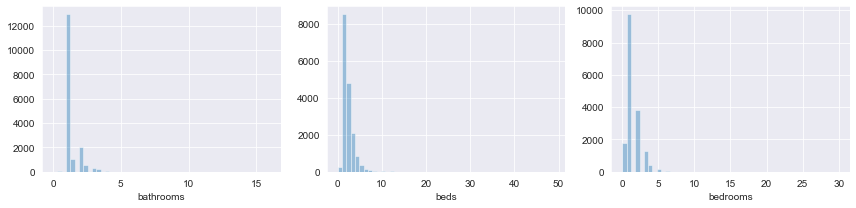

In [34]:
# quantitative variables with small proportion of missing values
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
for (i, col) in enumerate(['bathrooms', 'beds', 'bedrooms']):
    sns.distplot(listings_df[col].dropna(), ax=axs[i], kde=False)
fig.tight_layout()

Each of these variables is highly peaked and highly right skewed, so the imputing them with the mode (instead of mean or median) is a reasonable choice

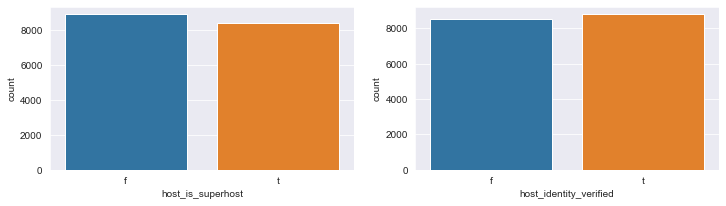

In [35]:
# categorical variables with small proportion of missing values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
for (i, col) in enumerate(['host_is_superhost', 'host_identity_verified']):
    sns.countplot(listings_df[col].dropna(), ax=axs[i % 2])

These binary variables are fairly evenly distributed, so the imputing them with mode is a reasonable choice.

In [36]:
# dictionary for imputation methods for columns with missing values
impute_vals = defaultdict(None)
# imputation values for some columns
for col in ['bathrooms', 'beds', 'bedrooms', 'host_since',
            'host_is_superhost', 'host_identity_verified']:
    impute_vals[col] = listings_df[col].mode().values[0]

Now let's look at the distributions of `cleaning_fee` and  `security_deposit`

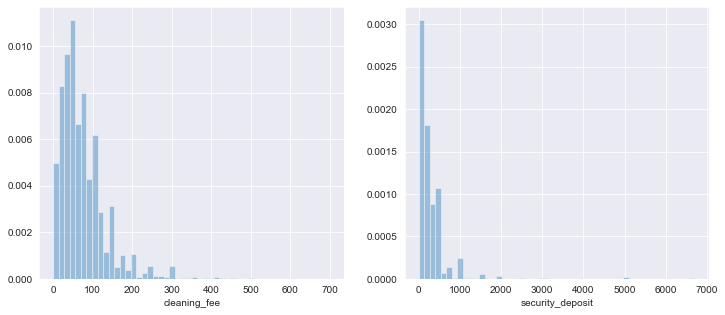

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for (i, col) in enumerate(['cleaning_fee', 'security_deposit']):
    sns.distplot(listings_df[col].dropna(), kde=False, norm_hist=True, ax=axs[i])

Given the large peak around zero for `security_deposit` and the fact that it seems reasonable to assign a value of zero to a listing that doesn't have security deposit information available, we'll use this for our imputation value. We'll use median for `cleaning_fee`, since it's highly peaked and skewed at a non-zero value.

In [38]:
# imputation values for more columns
impute_vals['security_deposit'] = 0
impute_vals['cleaning_fee'] = listings_df['cleaning_fee'].dropna().median()

Finally let's look at the distributions of `host_response_rate` and `host_response_time`

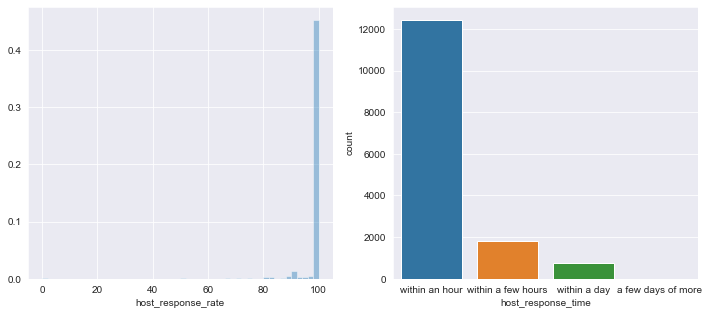

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.distplot(listings_df['host_response_rate'].dropna(), kde=False, norm_hist=True, ax=axs[0])
sns.countplot(listings_df['host_response_time'].dropna(), ax=axs[1])

Given the large skewness and peaks, we'll impute these with mode as well

In [40]:
# last imputation values
for col in ['host_response_rate', 'host_response_time']:
    impute_vals[col] = listings_df[col].mode().values[0]

In [41]:
# impute all missing values
listings_df = listings_df.fillna(impute_vals)

##### Downcast dtypes

In the last section we noted that some float variables could be downcast to ints to speed up computation. We'll do that now.

In [42]:
# downcast to int
listings_df.loc[:, conv_dtypes['int']] = listings_df[conv_dtypes['int']].astype('int') 

Now that we have no missing values, we can also cast some categorical to boolean dtypes

In [43]:
def conv_to_bool(entry):
    """Convert string entries to booleans."""
    return entry == 't'

conv_dtypes['bool'] = {'host_identity_verified', 'host_is_superhost', 
                       'instant_bookable', 'is_business_travel_ready', 
                       'require_guest_phone_verification',
                       'require_guest_profile_picture', 'requires_license'}

# downcast to boolean
listings_df = conv_cols(listings_df, conv_dtypes, conv_to_bool, 'bool') 

#### `calendar` dataset

##### Drop rows/columns

We check for duplicates

In [44]:
num_dups = calendar_df.duplicated().sum()
num_dups

0

Next we'll looks at rows or columns containing a lot of missing values. We'll choose a lower threshold of 25% missing values

In [45]:
# rows with high proportion of missing values in listings df
prop_missing_vals_df(calendar_df, axis=1)

prop_miss_vals
city                             
portland  386662         0.285714
vancouver 1333997        0.285714
portland  1432357        0.285714
          1432358        0.285714
          1432359        0.285714
...                           ...
          386417         0.285714
          386418         0.285714
          386419         0.285714
          386413         0.285714
          386411         0.285714

[718 rows x 1 columns]

In [46]:
# columns with high proportion of missing values in listings df
prop_missing_vals_df(calendar_df, axis=0)

,prop_miss_vals


No columns are missing >25% of values, but 718 rows are missing about 28.5% of values. We'll look closer at these rows.

In [47]:
# rows missing values
miss_vals_df = calendar_df.loc[calendar_df.isna().sum(axis=1) > 0]
miss_vals_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 718 entries, ('seattle', 2347737) to ('vancouver', 1334195)
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   listing_id      718 non-null    int64 
 1   date            718 non-null    object
 2   available       718 non-null    object
 3   price           0 non-null      object
 4   adjusted_price  0 non-null      object
 5   minimum_nights  718 non-null    int64 
 6   maximum_nights  718 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 25.2+ MB


All the missing values are present in the `price` and `adjusted_price` columns, and all the missing values are in the same 718 rows.

In [48]:
# indexes of calendar entries with missing values
miss_cal_idx = miss_vals_df.reset_index(level=0)\
               .groupby(['city', 'listing_id'])['listing_id'].count()
miss_cal_idx

city       listing_id
portland   6019539         7
           8902221       187
           26605745        7
           33046379      171
seattle    30408758      175
vancouver  31444945      171
Name: listing_id, dtype: int64

The missing calendar rows are concentrated in just six listing ids. Four of these listing ids are missing a large number of entries (around half a year of data), we'll drop these from both data sets. 

In [49]:
# drop listing ids with large number of missing entries
listing_ids = {index[1] for index in miss_cal_idx[miss_cal_idx > 7].index}
list_ids_mask = ~ listings_df['id'].apply(lambda x: x in listing_ids)
listings_df = listings_df[list_ids_mask]
cal_ids_mask = ~ calendar_df['listing_id'].apply(lambda x: x in listing_ids)
calendar_df = calendar_df[cal_ids_mask]

We'll also drop `adjusted_price`.This appears to be a variable added by InsideAirBnB, but couldn't find any information about it. Furthermore, we assume `price` in the `calendar` dataset is the equivalent to `price` in `listings`

In [50]:
calendar_df = calendar_df.drop(columns=['adjusted_price'])

##### Enforce dtypes

In [51]:
calendar_df.dtypes

listing_id         int64
date              object
available         object
price             object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [52]:
# set dtypes
calendar_df.loc[:, 'date'] = calendar_df['date'].astype('datetime64')
conv_dtypes = defaultdict(set)
conv_dtypes['bool'] = {'available'}
conv_dtypes['float'] = {'price'}
calendar_df = conv_cols(calendar_df, conv_dtypes, conv_to_bool, 'bool')
calendar_df = conv_cols(calendar_df, conv_dtypes, conv_to_float, 'float')

##### Missing Values

Finally we'll inspect the rows with missing values in `calendar` for the two listings which only had seven missing values

In [53]:
# inspect calendar df for listings missing seven values
listing_ids = [index[1] for index in miss_cal_idx[miss_cal_idx <= 7].index]
cal_id_mask = (calendar_df['listing_id'].apply(lambda x: x in listing_ids) &
               (calendar_df['price'].isna()))
two_listings_df = calendar_df[cal_id_mask]
two_listings_df

listing_id       date  available  price  minimum_nights  \
city                                                                        
portland 263694      6019539 2020-11-01      False    NaN               1   
         263695      6019539 2020-11-02      False    NaN               1   
         263696      6019539 2020-11-03      False    NaN               1   
         263697      6019539 2020-11-04      False    NaN               1   
         263698      6019539 2020-11-05      False    NaN               1   
         263699      6019539 2020-11-06      False    NaN               1   
         263700      6019539 2020-11-07      False    NaN               1   
         1113409    26605745 2020-11-01      False    NaN              30   
         1113410    26605745 2020-11-02      False    NaN              30   
         1113411    26605745 2020-11-03      False    NaN              30   
         1113412    26605745 2020-11-04      False    NaN              30   
         1113413    26605745 2020-11-05      False    NaN              30   
         1113414    26605745 2020-11-06      False    NaN              30   
         1113415    26605745 2020-11-07      False    NaN              30   

                  maximum_nights  
city                              
portland 263694             1125  
         263695             1125  
         263696             1125  
         263697             1125  
         263698             1125  
         263699             1125  
         263700             1125  
         1113409              90  
         1113410              90  
         1113411              90  
         1113412              90  
         1113413              90  
         1113414              90  
         1113415              90

These missing values are all in the same week. It makes sense to backfill with prices from the corresponding days on the previous week.

In [54]:
def backfill_missing_prices(calendar_df, two_listings_df):
    """Backfill missing price data for two listings in calendar dataset."""
    week_delta = pd.Timedelta(1, unit='w')
    calendar_df_cp = calendar_df.copy()
    for index in two_listings_df.index:
        listing_id = two_listings_df.loc[index]['listing_id']
        one_week_ago = two_listings_df.loc[index]['date'] - week_delta
        mask = ((calendar_df_cp['listing_id'] == listing_id) & 
               (calendar_df_cp['date'] == one_week_ago))
        price = calendar_df_cp[mask]['price'].values[0]
        calendar_df_cp.loc[index, 'price'] = price
    return calendar_df_cp

calendar_df = backfill_missing_prices(calendar_df, two_listings_df)

In [55]:
# check backfill worked
len(calendar_df[(cal_id_mask) &  calendar_df['price'].isna()])

0

##### Synchronize `date`

The data for Vancouver and Portland was collected earlier than for Seattle, so we'll make sure to sync up dates.

In [56]:
min_date = calendar_df.loc['seattle']['date'].min()
max_date = calendar_df.loc['vancouver']['date'].max()
cal_date_mask = ((calendar_df['date'] >= min_date) & (calendar_df['date'] <= max_date))
calendar_df = calendar_df[cal_date_mask]

### Create amenities features.

There's a lot of potentially useful information in the `amentities` column but it's going to take a little bit of work to get it. Currently the entries in the amenities columns are long strings containing amenities for that listing.

In [57]:
amenities_series = listings_df['amenities']
amenities_series

city           
seattle    0       {Internet,Wifi,Kitchen,"Free parking on premis...
           1       {TV,Internet,Wifi,"Free street parking",Heatin...
           2       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
           3       {Internet,Wifi,"Air conditioning",Kitchen,"Fre...
           4       {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
                                         ...                        
vancouver  6055    {TV,Wifi,Pool,Kitchen,"Free parking on premise...
           6063    {Wifi,"Air conditioning","Free street parking"...
           6064    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
           6073    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
           6091    {TV,Wifi,Kitchen,"Free parking on premises","H...
Name: amenities, Length: 17299, dtype: object

To proceed we need to do a bit of processing.

In [58]:
def process_amenities(amenities_series):
    """Process entries in amenities series."""
    # convert amenities lists into sets of strings
    amenities_series = amenities_series.apply(lambda x: set(x.split(',')))
    # set for tracking unique amenities
    amenities_set = set()
    # for dropping all non alphanumeric characters
    regex = re.compile('[^0-9a-zA-Z ]+')
    # function for processing each amenity lists in series entries
    def process_and_add(amenities_set, regex, amens_entry):
        new_amens_entry = set()
        for amen in amens_entry:
            # drop non alpha numeric
            amen = regex.sub('', amen)
            # don't keep track of translation failures
            if 'translation' in amen:
                pass
            else:
                new_amens_entry.add(amen)
                # add to main set if it hasn't been seen
                if amen not in amenities_set:
                    amenities_set.add(amen)
        return new_amens_entry
    # process amenity list entries in series
    apply_func = partial(process_and_add, amenities_set, regex)
    amenities_series = amenities_series.apply(apply_func)

    return amenities_series, amenities_set


def rename_amenities(amenities_series, amenities_set, amenities_mapping):
    """Clean up amenities names."""
    amenities_set = {amen if amen not in amenities_mapping
                     else amenities_mapping[amen] for amen in amenities_set}
    amenities_set = {'amen_' + amen.replace(' ', '_').lower() for amen
                     in amenities_set}

    # function for renaming amenity lists in series entries
    def rename_amens(amenities_mapping, amens_entry):
        new_amens_entry = set()
        for amen in amens_entry:
            try:
                amen = amenities_mapping[amen]
            except KeyError:
                pass
            amen = 'amen_' + amen.replace(' ', '_').lower()
            new_amens_entry.add(amen)
        return new_amens_entry

    # process amenity list entries in series
    apply_func = partial(rename_amens, amenities_mapping)
    amenities_series = amenities_series.apply(apply_func)

    return amenities_series, amenities_set

In [59]:
# get renamed series and set of amenities
amenities_series, amenities_set = process_amenities(
                                      listings_df['amenities'])
amenities_mapping = {' toilet': 'Toilet',
                     '24hour checkin': '24 hour checkin',
                     'Accessibleheight bed': 'Accessible height bed',
                     'Accessibleheight toilet':
                     'Accessible height toilet',
                     'Buzzerwireless intercom': 'Buzzer/Wireless intercom',
                     'Familykid friendly': 'Family/kid friendly',
                     'Highresolution computer monitor':
                     'High resolution computer monitor',
                     'Pack n Playtravel crib': 'Pack-n-Play travel crib',
                     'Roomdarkening shades': 'Room darkening shades',
                     'Self checkin': 'Self check-in',
                     'SkiinSkiout': 'Ski-in/Ski-out',
                     'Stepfree shower': 'Step-free shower',
                     'Washer  Dryer': 'Washer/Dryer',
                     'Welllit path to entrance':
                     'Well-lit path to entrance'}
amenities_series, amenities_set = rename_amenities(amenities_series,
                                                   amenities_set,
                                                   amenities_mapping)

Now we have a series of lists of cleaned up amenity names

In [60]:
amenities_series

city           
seattle    0       {amen_lake_access, amen_childrens_books_and_to...
           1       {amen_24_hour_checkin, amen_tv, amen_lockbox, ...
           2       {amen_24_hour_checkin, amen_tv, amen_hair_drye...
           3       {amen_dogs, amen_private_living_room, amen_hai...
           4       {amen_wide_hallways, amen_tv, amen_hair_dryer,...
                                         ...                        
vancouver  6055    {amen_tv, amen_pool, amen_hair_dryer, amen_gym...
           6063    {amen_garden_or_backyard, amen_wide_entrance, ...
           6064    {amen_wide_hallways, amen_lake_access, amen_tv...
           6073    {amen_lake_access, amen_paid_parking_off_premi...
           6091    {amen_tv, amen_lockbox, amen_hair_dryer, amen_...
Name: amenities, Length: 17299, dtype: object

And a set of all unique amenities. Let's see how many there are

In [61]:
# count number of unique amenities
len(amenities_set)

190

Let's whittle this number down by taking amenities which are don't have extremely unbalanced distributions. We'll find amenities present in more than 10% but less than 90% of listings.

In [62]:
def count_amenities(amenities_series, amenities_set):
    """Count total occurences of each amenity in dataset."""
    amenities_count = {amen: 0 for amen in amenities_set}

    for amens_entry in amenities_series:
        for amen in amens_entry:
            amenities_count[amen] += 1

    return amenities_count

def get_amenities_cols(amenities_series, amenities_count,
                       prop_low=0.1, prop_hi=0.9):
    """Return amenities with proportion in between thresholds."""
    # dataframe of amenities counts
    n = len(amenities_series)
    amenities_prop_df = pd.DataFrame(amenities_count, index=['prop']).T
    amenities_prop_df = amenities_prop_df.sort_values(by='prop')/n
    amenities_prop_df = amenities_prop_df.query('prop >= ' + str(prop_low))
    amenities_prop_df = amenities_prop_df.query('prop <= ' + str(prop_hi))

    return set(amenities_prop_df.index)

In [63]:
# get amenities present in > 10% and less than 90% of listings
amenities_count = count_amenities(amenities_series, amenities_set)
amenities_cols = get_amenities_cols(amenities_series, amenities_count,
                                    prop_low=0.1, prop_hi=0.9)
# check number of these
len(amenities_cols)

51

That's a more reasonable number of amenities for us to consider. Finally we'll create a dataframe of boolean variables the presence/absence of these amenities for each listing. We'll also include a variable which counts the number of these amenities present for each listing 

In [64]:
def get_amenities_df(amenities_series, amenities_cols):
    """Create dataframe of amenities variables."""
    amenities_df = pd.DataFrame(columns=amenities_cols,
                                index=amenities_series.index).astype('bool')

    def has_amenity(amenity, amens_entry):
        return amenity in amens_entry

    for amenity in amenities_cols:
        applyfunc = partial(has_amenity, amenity)
        amenities_df.loc[:, amenity] = amenities_series.apply(applyfunc)

    def num_amenities(amenities_cols, amen_entry):
        return len(set(amen_entry).intersection(amenities_cols))

    applyfunc = partial(num_amenities, amenities_cols)
    amenities_df['num_amenities'] = amenities_series.apply(applyfunc)

    return amenities_df

In [65]:
# dataframe with amenities as boolean columns
amenities_df = get_amenities_df(amenities_series, amenities_cols)
amenities_df

amen_garden_or_backyard  amen_childrens_books_and_toys  \
city                                                                     
seattle   0                       False                           True   
          1                       False                          False   
          2                       False                          False   
          3                       False                          False   
          4                       False                          False   
...                                 ...                            ...   
vancouver 6055                    False                          False   
          6063                     True                          False   
          6064                    False                          False   
          6073                    False                          False   
          6091                    False                          False   

                amen_24_hour_checkin  amen_tv  amen_private_living_room  \
city                                                                      
seattle   0                    False    False                     False   
          1                     True     True                     False   
          2                     True     True                     False   
          3                    False    False                      True   
          4                    False     True                     False   
...                              ...      ...                       ...   
vancouver 6055                 False     True                     False   
          6063                 False    False                      True   
          6064                 False     True                      True   
          6073                 False     True                      True   
          6091                 False     True                     False   

                amen_pets_live_on_this_property  amen_lockbox  \
city                                                            
seattle   0                               False         False   
          1                               False          True   
          2                               False         False   
          3                                True         False   
          4                               False         False   
...                                         ...           ...   
vancouver 6055                            False         False   
          6063                            False         False   
          6064                            False         False   
          6073                            False         False   
          6091                            False          True   

                amen_long_term_stays_allowed  amen_gym  amen_cable_tv  \
city                                                                    
seattle   0                             True     False          False   
          1                            False     False          False   
          2                            False     False          False   
          3                            False     False          False   
          4                            False     False           True   
...                                      ...       ...            ...   
vancouver 6055                         False      True          False   
          6063                          True     False          False   
          6064                          True     False           True   
          6073                          True     False           True   
          6091                         False     False          False   

                amen_family/kid_friendly  amen_hair_dryer  \
city                                                        
seattle   0                         True             True   
          1                         True             True   
          2                        Fa

And finally, we'll add this to our listings dataframe

In [66]:
# add amenities to listings df
listings_df = pd.concat([listings_df, amenities_df], axis=1)\
              .drop(columns=['amenities'])

### Currency conversion

The Vancouver prices are expressed in CAD, so we'll convert to USD. The exchange rate as of November 26, 2019 was 1 CAD = 0.75341 USD.

In [67]:
def conv_cad_to_usd(entry):
    """Currency conversion helper."""
    return round(0.75341 * entry, 0)

def conv_curr_cols(df, curr_cols, curr_conv_func):
    """Convert currency columns."""
    df_cp = df.copy()
    df_cp.loc[:, curr_cols] = \
        df_cp[curr_cols].apply(lambda x: conv_cad_to_usd(x) 
                               if 'vancouver' in x.name else x, axis=1)
    return df_cp

In [68]:
# convert currency columns in listings df
list_curr_cols = ['cleaning_fee', 'price', 'security_deposit']
listings_df = conv_curr_cols(listings_df, list_curr_cols, conv_cad_to_usd)

In [91]:
# workaround for converting calendar columns due to slowness of conv_curr_cols
cal_van_price = calendar_df.loc['vancouver']['price'].apply(conv_cad_to_usd).values
cal_other_price = calendar_df.loc[['seattle', 'portland']]['price'].values
calendar_df.loc[:, 'price'] = np.append(cal_other_price, cal_van_price)

### Save cleaned datasets

In [92]:
# save dfs as h5 files to save write time
listings_df = alphabetize_cols(listings_df)
listings_df.to_hdf('data/listings.h5', key='listings', mode='w', format='table')
calendar_df = alphabetize_cols(calendar_df, first_col='listing_id')
calendar_df.to_hdf('data/calendar.h5', key='calendar', mode='w', format='table')